# Autoregressive Moving Average (ARMA): Sunspots data

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from statsmodels.graphics.api import qqplot

## Sunspots Data

In [4]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [5]:
dta = sm.datasets.sunspots.load_pandas().data

In [6]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
dta.index.freq = dta.index.inferred_freq
del dta["YEAR"]

<AxesSubplot:>

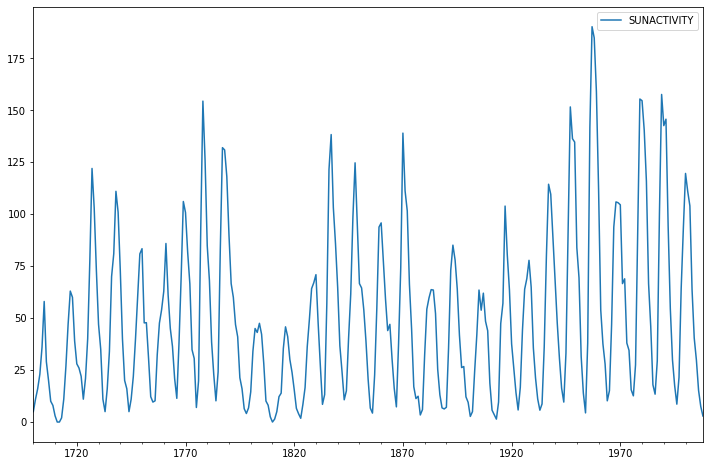

In [7]:
dta.plot(figsize=(12, 8))

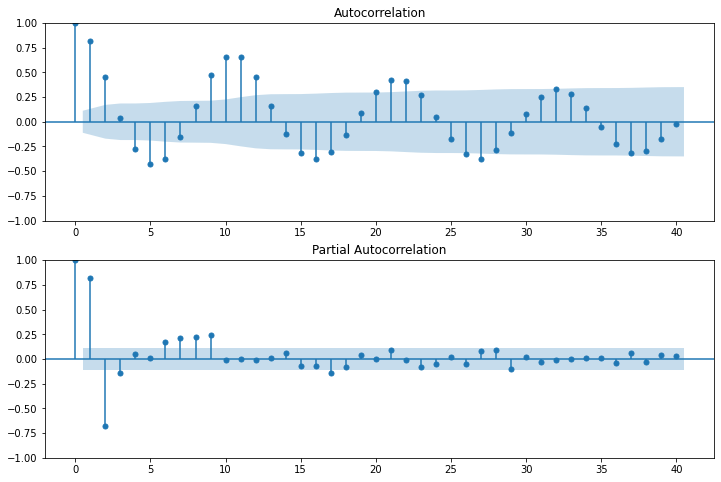

In [8]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [9]:
arma_mod20 = ARIMA(dta, order=(2, 0, 0)).fit()
print(arma_mod20.params)

const      49.746198
ar.L1       1.390633
ar.L2      -0.688573
sigma2    274.727181
dtype: float64


In [10]:
arma_mod30 = ARIMA(dta, order=(3, 0, 0)).fit()

In [11]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2622.6370933008184 2637.570458408409 2628.6074811460644


In [12]:
print(arma_mod30.params)

const      49.751911
ar.L1       1.300818
ar.L2      -0.508102
ar.L3      -0.129644
sigma2    270.101140
dtype: float64


In [13]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

2619.4036292456613 2638.07033563015 2626.8666140522187


* Does our model obey the theory?

In [14]:
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9564953610769797

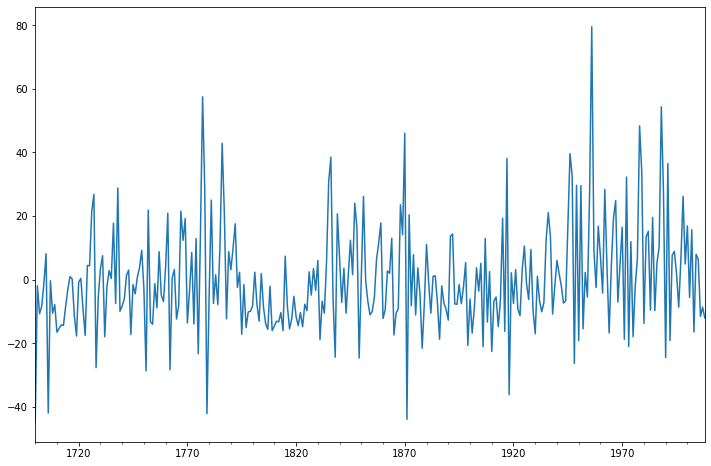

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)

In [16]:
resid = arma_mod30.resid

In [17]:
stats.normaltest(resid)

NormaltestResult(statistic=49.84393222775048, pvalue=1.5015079588990436e-11)

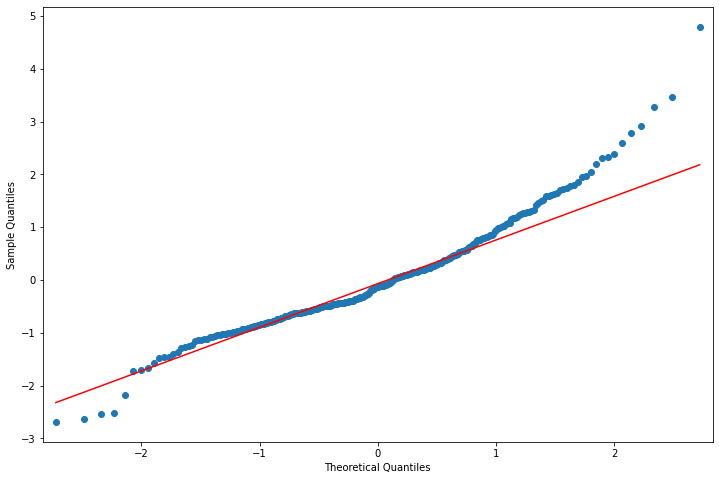

In [18]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

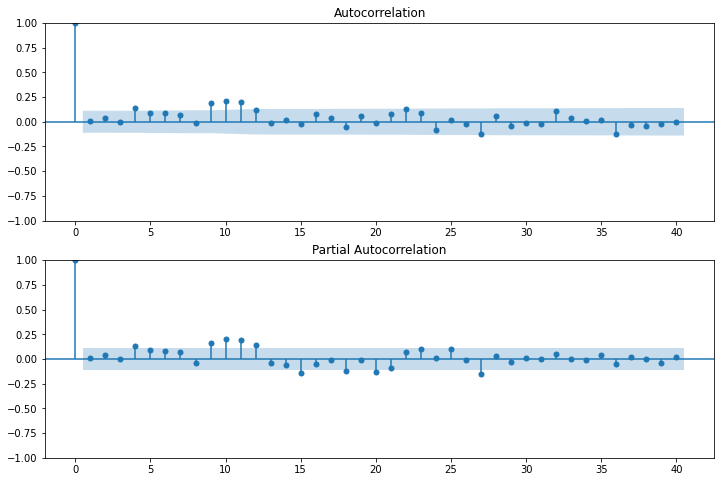

In [19]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [20]:
r, q, p = sm.tsa.acf(resid.values.squeeze(), fft=True, qstat=True)
data = np.c_[np.arange(1, 25), r[1:], q, p]

In [21]:
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.009170   0.026239  8.713184e-01
2.0   0.041793   0.572982  7.508939e-01
3.0  -0.001338   0.573544  9.024612e-01
4.0   0.136086   6.408642  1.706385e-01
5.0   0.092465   9.111351  1.047043e-01
6.0   0.091947  11.792661  6.675737e-02
7.0   0.068747  13.296552  6.520425e-02
8.0  -0.015022  13.368601  9.978086e-02
9.0   0.187590  24.641072  3.394963e-03
10.0  0.213715  39.320758  2.230588e-05
11.0  0.201079  52.359565  2.346490e-07
12.0  0.117180  56.802479  8.580351e-08
13.0 -0.014057  56.866630  1.895209e-07
14.0  0.015398  56.943864  4.000370e-07
15.0 -0.024969  57.147642  7.746545e-07
16.0  0.080916  59.295052  6.876728e-07
17.0  0.041138  59.852008  1.111674e-06
18.0 -0.052022  60.745723  1.549418e-06
19.0  0.062496  62.040011  1.832778e-06
20.0 -0.010303  62.075305  3.383285e-06
21.0  0.074453  63.924941  3.195540e-06
22.0  0.124954  69.152954  8.984238e-07
23.0  0.093162  72.069214  5.803579e-07


* This indicates a lack of fit.

* In-sample dynamic prediction. How good does our model do?

In [22]:
predict_sunspots = arma_mod30.predict("1990", "2012", dynamic=True)
print(predict_sunspots)

1990-12-31    167.048337
1991-12-31    140.995022
1992-12-31     94.862115
1993-12-31     46.864439
1994-12-31     11.246106
1995-12-31     -4.718265
1996-12-31     -1.164628
1997-12-31     16.187246
1998-12-31     39.022948
1999-12-31     59.450799
2000-12-31     72.171269
2001-12-31     75.378329
2002-12-31     70.438480
2003-12-31     60.733987
2004-12-31     50.204383
2005-12-31     42.078584
2006-12-31     38.116648
2007-12-31     38.456730
2008-12-31     41.965644
2009-12-31     46.870948
2010-12-31     51.424878
2011-12-31     54.401403
2012-12-31     55.323515
Freq: A-DEC, Name: predicted_mean, dtype: float64


In [23]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [24]:
mean_forecast_err(dta.SUNACTIVITY, predict_sunspots)

5.634832970674399

### Exercise: Can you obtain a better fit for the Sunspots model? (Hint: sm.tsa.AR has a method select_order)

### Simulated ARMA(4,1): Model Identification is Difficult

In [27]:
from statsmodels.tsa.arima_process import ArmaProcess

In [28]:
np.random.seed(1234)
# include zero-th lag
arparams = np.array([1, 0.75, -0.65, -0.55, 0.9])
maparams = np.array([1, 0.65])

Let's make sure this model is estimable.

In [29]:
arma_t = ArmaProcess(arparams, maparams)

In [30]:
arma_t.isinvertible

True

In [31]:
arma_t.isstationary

False

* What does this mean?

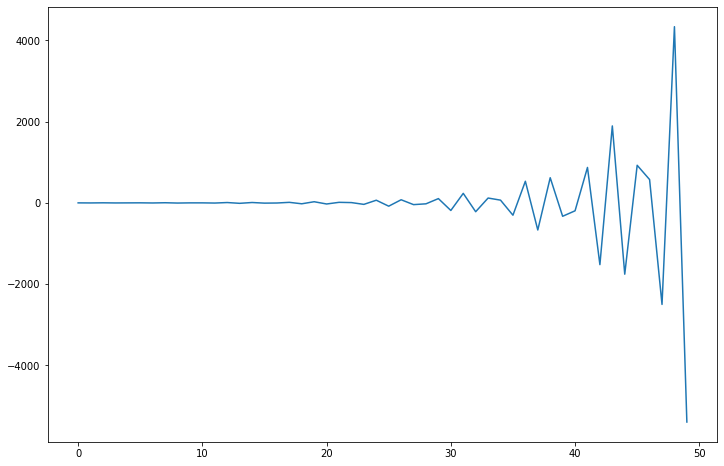

In [32]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(arma_t.generate_sample(nsample=50))

In [33]:
arparams = np.array([1, 0.35, -0.15, 0.55, 0.1])
maparams = np.array([1, 0.65])
arma_t = ArmaProcess(arparams, maparams)
arma_t.isstationary

True

In [34]:
arma_rvs = arma_t.generate_sample(nsample=500, burnin=250, scale=2.5)

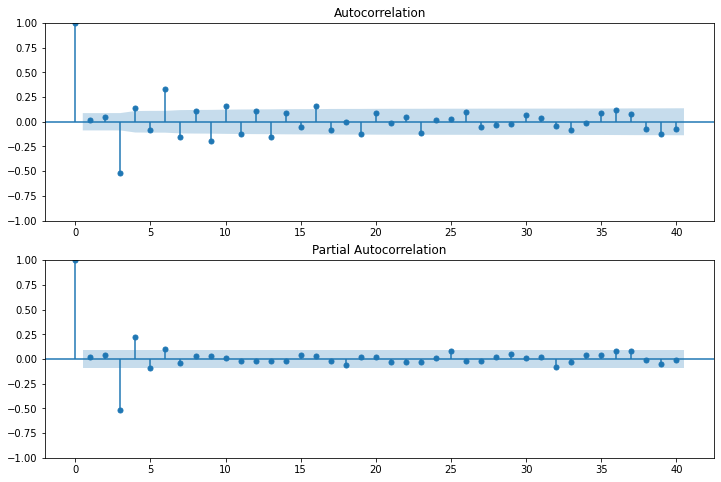

In [35]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_rvs, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_rvs, lags=40, ax=ax2)

* For mixed ARMA processes the Autocorrelation function is a mixture of exponentials and damped sine waves after (q-p) lags.
* The partial autocorrelation function is a mixture of exponentials and dampened sine waves after (p-q) lags.

In [36]:
lags = int(10 * np.log10(arma_rvs.shape[0]))
arma11 = ARIMA(arma_rvs, order=(1, 0, 1)).fit()
resid = arma11.resid
r, q, p = sm.tsa.acf(resid, nlags=lags, fft=True, qstat=True)
data = np.c_[range(1, lags + 1), r[1:], q, p]
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

            AC           Q      Prob(>Q)
lag                                     
1.0  -0.001244    0.000778  9.777436e-01
2.0   0.052350    1.382049  5.010626e-01
3.0  -0.522181  139.090106  5.938064e-30
4.0   0.146506  149.951983  2.084573e-31
5.0  -0.091171  154.166872  1.731083e-31
6.0   0.337059  211.891306  5.568290e-43
7.0  -0.160920  225.075262  5.519054e-45
8.0   0.116132  231.955610  1.142179e-45
9.0  -0.195352  251.464207  4.895753e-49
10.0  0.166410  265.649428  2.760836e-51
11.0 -0.126465  273.858717  2.767679e-52
12.0  0.115015  280.662675  5.334652e-53
13.0 -0.159302  293.742050  4.899046e-55
14.0  0.095846  298.486519  2.444596e-55
15.0 -0.062853  300.531001  4.335557e-55
16.0  0.159244  313.681886  3.718133e-57
17.0 -0.089423  317.837388  2.317190e-57
18.0  0.002504  317.840655  1.018533e-56
19.0 -0.124735  325.959706  9.297882e-58
20.0  0.093960  330.576238  4.414194e-58
21.0 -0.016212  330.713970  1.708363e-57
22.0  0.054804  332.291098  3.279536e-57
23.0 -0.110592  

/home/shahid/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/shahid/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [37]:
arma41 = ARIMA(arma_rvs, order=(4, 0, 1)).fit()
resid = arma41.resid
r, q, p = sm.tsa.acf(resid, nlags=lags, fft=True, qstat=True)
data = np.c_[range(1, lags + 1), r[1:], q, p]
table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print(table.set_index("lag"))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.007899   0.031383  0.859389
2.0   0.004128   0.039972  0.980212
3.0   0.018095   0.205341  0.976722
4.0  -0.006766   0.228509  0.993949
5.0   0.018123   0.395044  0.995465
6.0   0.050690   1.700565  0.945078
7.0   0.010253   1.754087  0.972191
8.0  -0.011208   1.818176  0.986088
9.0   0.020292   2.028663  0.991006
10.0  0.001028   2.029204  0.996111
11.0 -0.014033   2.130285  0.997983
12.0 -0.023858   2.423052  0.998426
13.0 -0.002108   2.425342  0.999339
14.0 -0.018784   2.607562  0.999589
15.0  0.011317   2.673844  0.999805
16.0  0.042158   3.595554  0.999443
17.0  0.007943   3.628344  0.999734
18.0 -0.074312   6.504019  0.993685
19.0 -0.023378   6.789205  0.995255
20.0  0.002398   6.792213  0.997313
21.0  0.000488   6.792338  0.998515
22.0  0.017953   6.961578  0.999024
23.0 -0.038576   7.744617  0.998744
24.0 -0.029817   8.213410  0.998859
25.0  0.077850  11.415980  0.990674
26.0  0.040407  12.280577  0

### Exercise: How good of in-sample prediction can you do for another series, say, CPI

In [38]:
macrodta = sm.datasets.macrodata.load_pandas().data
macrodta.index = pd.Index(sm.tsa.datetools.dates_from_range("1959Q1", "2009Q3"))
cpi = macrodta["cpi"]

#### Hint: 

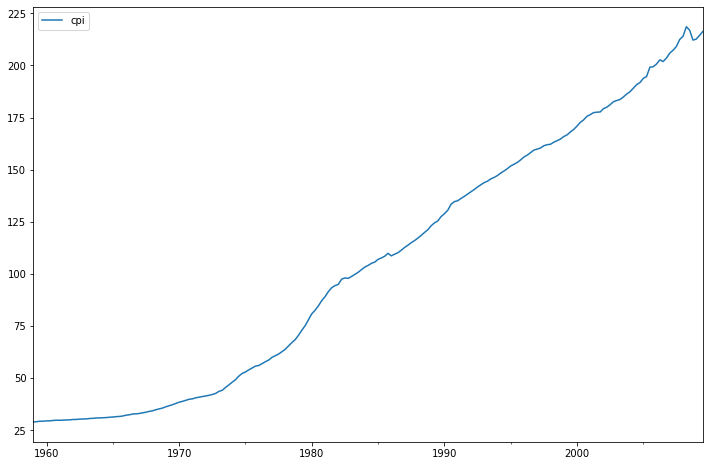

In [39]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = cpi.plot(ax=ax)
ax.legend()

P-value of the unit-root test, resoundingly rejects the null of a unit-root.

In [40]:
print(sm.tsa.adfuller(cpi)[1])

0.9904328188337422
